# Import required libraries

In [30]:
import os
import PIL
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

# Define hyperparameters

In [31]:
batch_size = 64
learning_rate = 1e-3
epochs = 10

# Load the dataset

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train', transform=transform)

train_size = int(0.8 * len(dataset))
test_size =  len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print("Training batch shape:", train_images.shape)
print("Testing batch shape:", test_images.shape)

class_names = dataset.classes 
print("Classes:", class_names)
num_classes = len(class_names)

Total samples: 87000
Training samples: 69600
Testing samples: 17400
Training batch shape: torch.Size([64, 3, 200, 200])
Testing batch shape: torch.Size([64, 3, 200, 200])
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


# Create dictionaries to map classes to labels and labels to classes

In [33]:
class_to_label = {class_name: idx for idx, class_name in enumerate(dataset.classes)}
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()}

print("Class-to-Label Mapping:", class_to_label)
print("Label-to-Class Mapping:", label_to_class)

Class-to-Label Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Label-to-Class Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}


# Plot few images from train_dataset


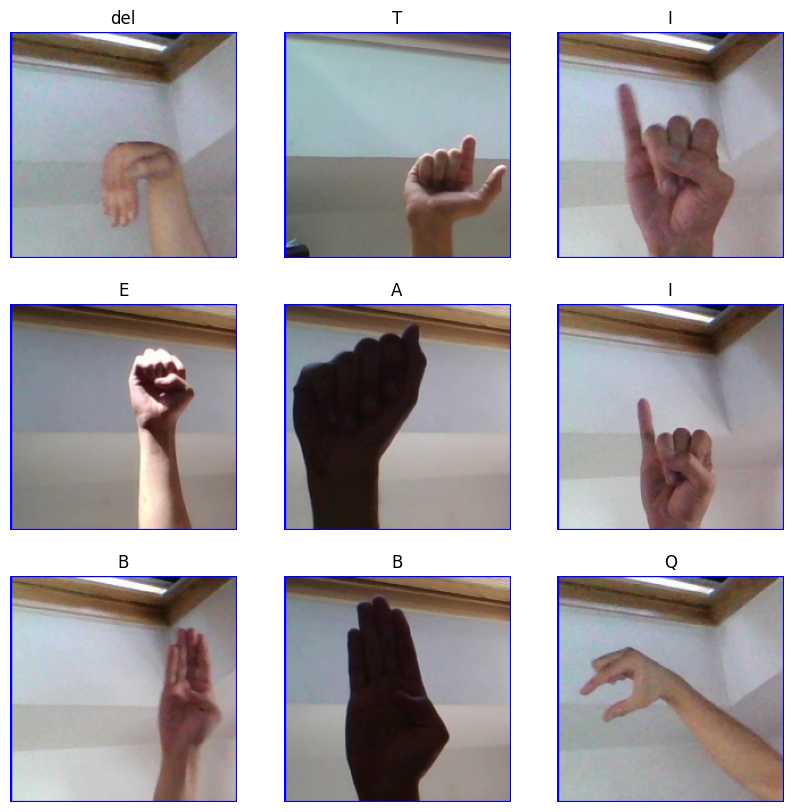

In [34]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    plt.title(label_to_class[train_labels[i].item()])
    plt.axis("off")

# Define the neural network

In [35]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5), #output_shape=(batch_size, 16, 196, 196)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output_shape=(batch_size, 16, 98, 98)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), #output_shape=(batch_size, 32, 94, 94)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output_shape=(batch_size, 32, 47, 47)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), #output_shape=(batch_size, 64, 43, 43)
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5), #output_shape=(batch_size, 128, 39, 39)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output_shape=(batch_size, 128, 19, 19)
            nn.Dropout(p=0.2),
            nn.Flatten(),
            nn.Linear(128 * 19 * 19, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        logits = self.convolution(x)
        return logits

In [36]:
model = ImageClassifier(num_classes=num_classes).to(device)

# Define the loss function and optimizer

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the training loop


In [38]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_losses_list = []
    train_total_correct = 0
    train_total_samples = 0

    model.train()

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device, dtype=torch.long)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses_list.append(loss.item())

        train_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_train_loss = sum(train_losses_list) / len(train_losses_list)
    avg_train_acc = train_total_correct / len(dataloader.dataset)

    return avg_train_loss, avg_train_acc

# Define the test loop

In [39]:
def test_loop(dataloader, model, loss_fn):
    
    test_losses_list = []
    test_total_correct = 0
    test_total_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device=device, dtype=torch.long)
            
            pred = model(x)
            loss = loss_fn(pred, y)
            
            test_losses_list.append(loss.item())

            test_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = sum(test_losses_list) / len(test_losses_list)
    avg_test_acc = test_total_correct / len(dataloader.dataset)
    return avg_test_loss, avg_test_acc

# Train the model and save the results in lists

In [40]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    start = time.time()
    avg_train_loss, avg_train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    avg_test_loss, avg_test_acc = test_loop(test_loader, model, loss_fn)
    

    train_acc_list.append(avg_train_acc)
    test_acc_list.append(avg_test_acc)
    train_loss_list.append(avg_train_loss)
    test_loss_list.append(avg_test_loss)

    print(f"Epoch: {epoch+1}/{epochs} - {round(time.time()-start)}s - Training accuracy: {avg_train_acc:.4f} - Training loss: {avg_train_loss:.4f} - Test accuracy: {avg_test_acc:.2f} - Test loss: {avg_test_loss:.2f}")

Epoch: 1/10 - 228s - Training accuracy: 0.6835 - Training loss: 1.0313 - Test accuracy: 0.95 - Test loss: 0.15
Epoch: 2/10 - 227s - Training accuracy: 0.9625 - Training loss: 0.1156 - Test accuracy: 0.98 - Test loss: 0.06
Epoch: 3/10 - 222s - Training accuracy: 0.9826 - Training loss: 0.0537 - Test accuracy: 0.99 - Test loss: 0.03
Epoch: 4/10 - 222s - Training accuracy: 0.9862 - Training loss: 0.0438 - Test accuracy: 0.99 - Test loss: 0.02
Epoch: 5/10 - 222s - Training accuracy: 0.9901 - Training loss: 0.0319 - Test accuracy: 0.99 - Test loss: 0.04
Epoch: 6/10 - 220s - Training accuracy: 0.9905 - Training loss: 0.0313 - Test accuracy: 0.99 - Test loss: 0.05
Epoch: 7/10 - 228s - Training accuracy: 0.9922 - Training loss: 0.0266 - Test accuracy: 0.99 - Test loss: 0.02
Epoch: 8/10 - 224s - Training accuracy: 0.9926 - Training loss: 0.0247 - Test accuracy: 1.00 - Test loss: 0.01
Epoch: 9/10 - 222s - Training accuracy: 0.9936 - Training loss: 0.0227 - Test accuracy: 0.99 - Test loss: 0.03
E

# make a plot for accuracy and loss 

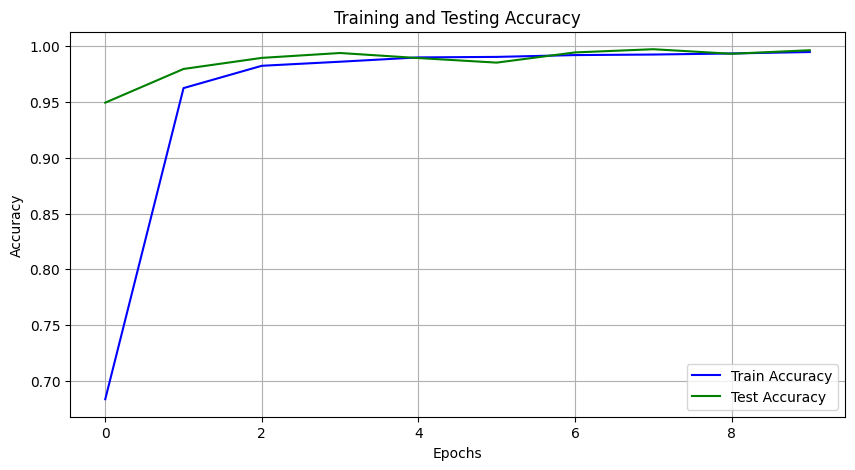

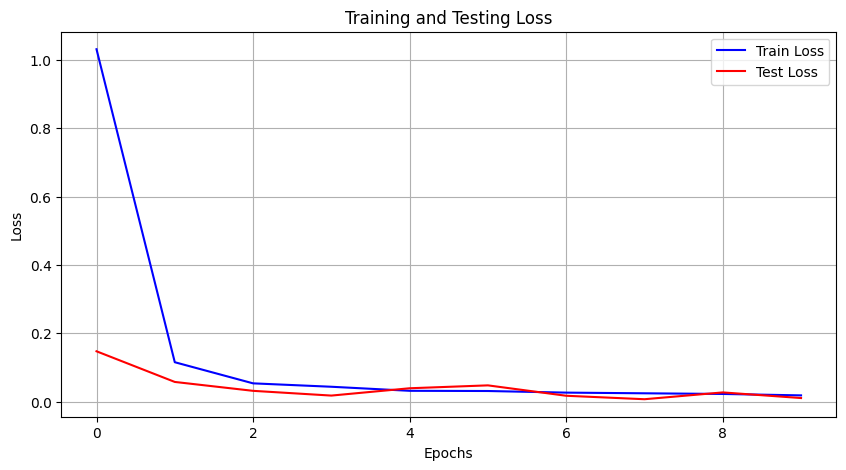

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_acc_list, label="Train Accuracy", color='blue')
plt.plot(range(epochs), test_acc_list, label="Test Accuracy", color='green')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss_list, label="Train Loss", color='blue')
plt.plot(range(epochs), test_loss_list, label="Test Loss", color='red')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make prediction on images in asl_alphabet_test directory

In [45]:
true_classes = []
val_images = []
for dirname, _, filenames in os.walk('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'):
    for filename in filenames:  
        true_classes.append(filename[0])
        
        path=os.path.join(dirname, filename)
        img = Image.open(path)
        img_tensor = transform(img)
        val_images.append(img_tensor)
val_dataset = torch.stack(val_images)

# `Note: In the list true_classes, 'n' refers to nothing and 's' refers to space`

In [46]:
model.eval()
with torch.no_grad():
    output = model(val_dataset.to(device))
output = output.cpu()
pred_labels = output.argmax(1).numpy()

# Plot the result

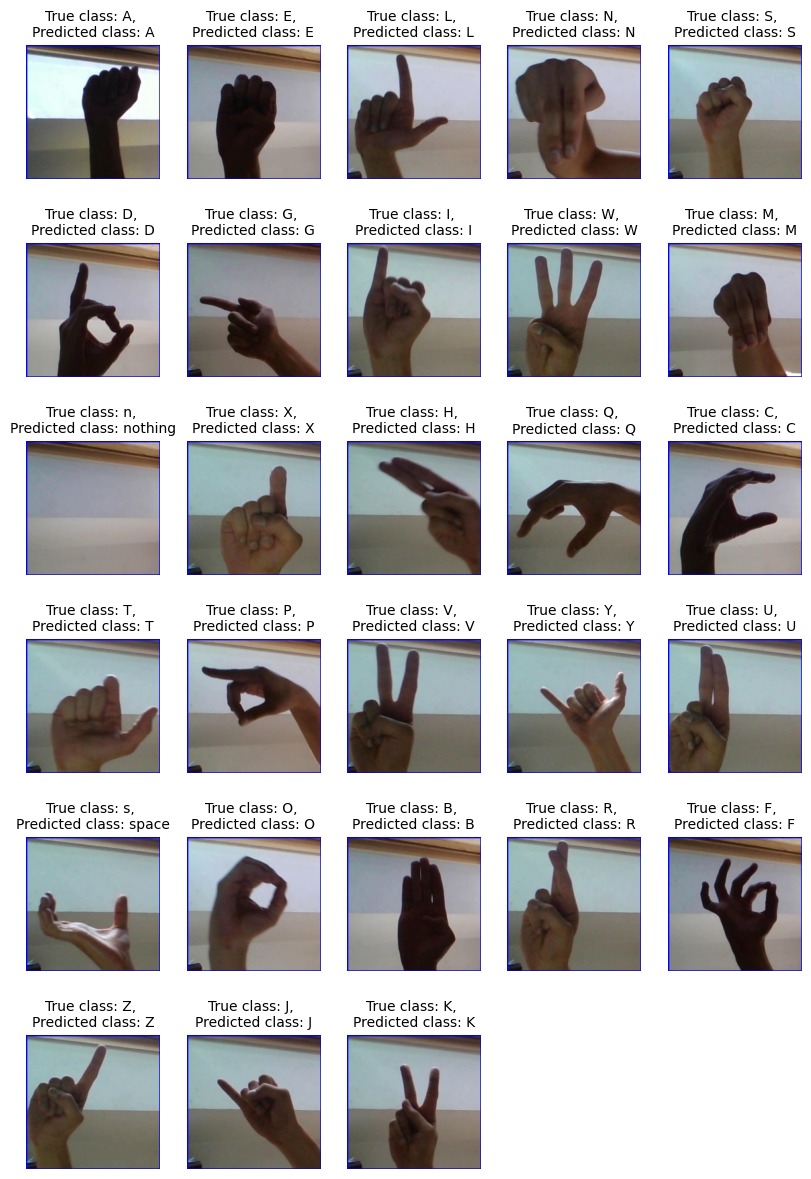

In [48]:
plt.figure(figsize=(10, 15))
for i in range(len(pred_labels)):
    plt.subplot(6, 5, i+1)
    plt.imshow(np.transpose(val_images[i].numpy(), (1, 2, 0)))
    plt.title(f"True class: {true_classes[i]}, \nPredicted class: {label_to_class[pred_labels[i]]}", fontsize=10)
    plt.axis("off")

# save model

In [50]:
torch.save(model.state_dict(), 'model_weights.pth')

In [51]:
torch.save(model.state_dict(), 'model_weights.h5')

### Loading the Model After Saving

To save the model weights, you can use the `state_dict`, and when you need to load it, first create a model with the same architecture and then load the saved weights.

1. **Create the model:**
   ```python
   model = ImageClassifier(num_classes=num_classes).to(device)


In [53]:
model = ImageClassifier(num_classes=num_classes).to(device)

model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  

<ipython-input-53-ca397b87f2a5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


ImageClassifier(
  (convolution): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=46208, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=29, bias=True)
  )
)

### Saving the Full Model

To save not only the model weights but also the optimizer state, epoch, and loss, you can use the following code:

1. **Save the full model:**
   ```python
   torch.save({
       'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'loss': avg_train_loss,
   }, 'full_model.pth')


In [54]:
#torch.save({
#    'epoch': epoch,
#    'model_state_dict': model.state_dict(),
#    'optimizer_state_dict': optimizer.state_dict(),
#    'loss': avg_train_loss,
#}, 'full_model.pth')

### Loading the Full Model

To load the saved model along with the optimizer state, epoch, and loss, use the following code:

1. **Load the checkpoint:**
   ```python
   checkpoint = torch.load('full_model.pth')


In [ ]:
#checkpoint = torch.load('full_model.pth')
#model = ImageClassifier(num_classes=num_classes).to(device)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']